In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier

# 1 Data Acquisition

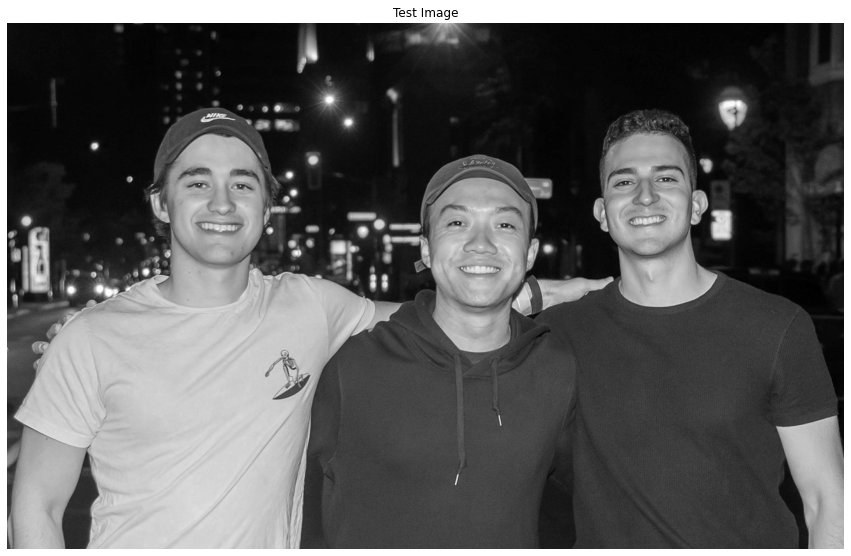

In [2]:
# read in test image
test_path = './data/test.jpg'
test_pic = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)

# Plot test image
plt.figure(figsize=(15, 10))
plt.title('Test Image')
plt.imshow(test_pic, 'gray'), plt.axis('off')
plt.show()

#### Resize and change color for training images

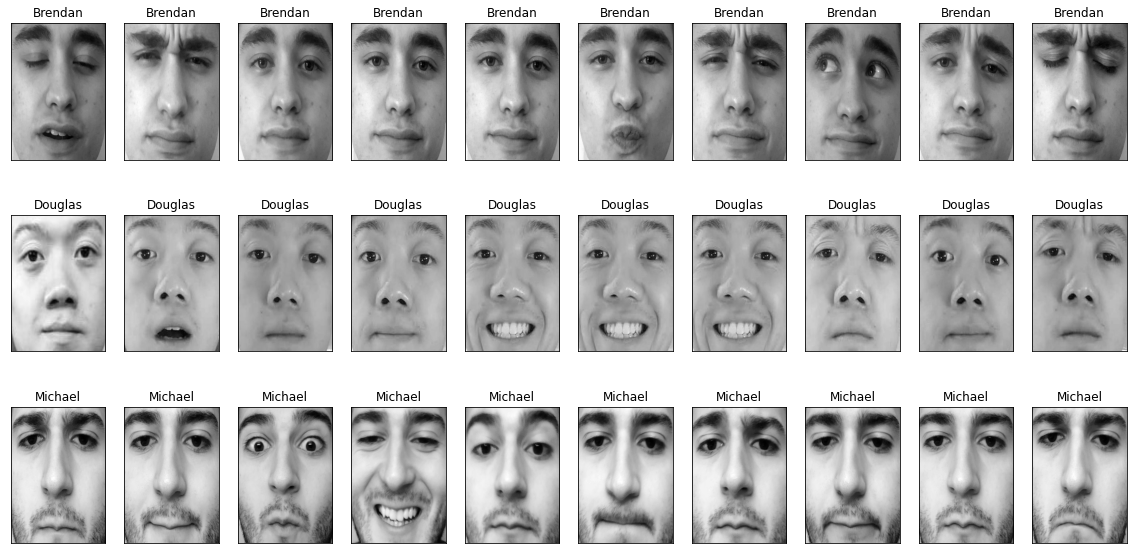

In [3]:
train_path = "./data/train/"

# read in all original train images to an array
images = []
subject = []

#new picture dimensions
width = 180
height = 260
dim = (width, height)

count = 0

for folder in os.listdir(train_path):
    subject_temp = []
    img_temp = []
    for file in glob.glob(train_path+folder+"/*.jpg"):
        img_temp.append(cv2.resize(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY), dim, interpolation = cv2.INTER_AREA))
        subject_temp.append(folder)
    subject = subject + subject_temp
    images = images + img_temp
    

#Display 5 example images of each individual
display_title = ["Chris Evans", "Chris Hemsworth", "Mark Ruffalo"]
plt.figure(figsize=(20, 10))
for i in range(30):
    plt.subplot(3,10,i+1), plt.imshow(images[i], cmap = 'gray')
    plt.title(subject[i])
    plt.xticks([]), plt.yticks([])
    
plt.show()

#### Describe how you selected the images with respect to the conditions of the detection/recognition methods?

As the PCA method is affected greatly by lighting conditions and occlusions, the traingng image set of each person is collected in the same lighting condition taking care not to have any occlusions or shadows. The only varible between the images is changes in experssion.
After collecting the images, they are all manually cropped to include just the subjects face and then resized. Also i am using grayscale images to reduce the computational complexity.
##### However, due to the social distancing measures put in place to combat the COVID-19 pandemic, the group test image is an older image taken in non ideal lighting conditions. There are also chages in hairstyle and beard of the people in the picture. This will cause some errors in detection/ recognition.

# 2 Eigenface Representation

In [4]:
pixels = height * width
total_images = 30

#convert images to vectors
img_vector = []

for img in images:
    face = img.reshape(pixels,)
    img_vector.append(face)
    
img_vector = np.asarray(img_vector)
img_vector = img_vector.transpose()

print("image vector shape: " + str(img_vector.shape))




image vector shape: (46800, 30)


In [5]:
# subtract mean
img_vector_mean = img_vector.mean(axis=1)
img_vector_mean = img_vector_mean.reshape(img_vector.shape[0], 1)
normalized_img_vector = img_vector - img_vector_mean


In [6]:
#sigma
covariance = np.cov(np.transpose(normalized_img_vector))


In [7]:
#Eigen vector
eigen_values, eigen_vectors = np.linalg.eig(covariance)
print (eigen_values)
print(eigen_vectors.shape)



[ 4.86272509e+03  3.83151820e+03  9.91195304e+02  8.91218978e+02
  7.35669666e+02  6.03388707e+02  4.56602952e+02  3.42756560e+02
  2.98531621e+02  2.80490803e+02  2.54846475e+02  2.15434856e+02
  1.99890295e+02  1.62305943e+02  1.48557858e+02  1.40379373e+02
  1.25243268e+02  1.15976590e+02  3.32343691e+01  3.66732121e+01
  5.09633476e+01  9.77636817e+01  9.23480493e+01  7.80228751e+01
  6.44560832e+01  6.50958963e+01  7.60595576e-14 -4.83671381e-14
  9.71283301e-15 -7.05755011e-15]
(30, 30)


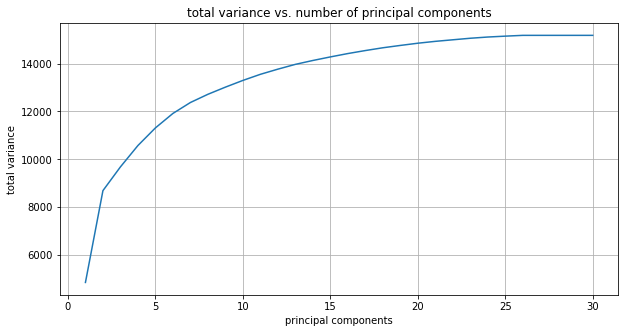

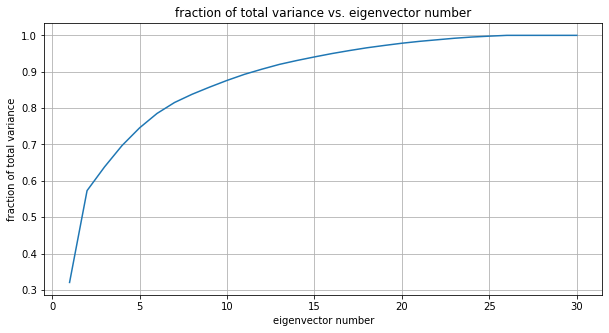

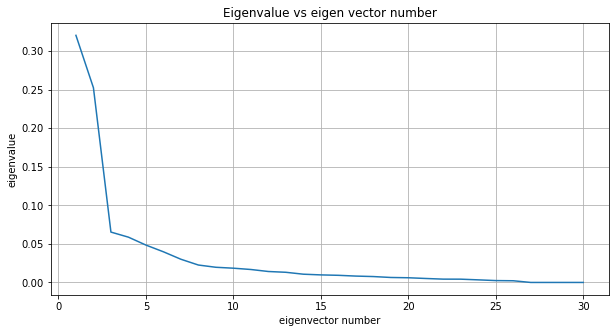

In [8]:
#sort
eigen_vectors = [eigen_vectors for _,eigen_vectors in sorted(zip(eigen_values,eigen_vectors), reverse = True)]
eigen_values = sorted(eigen_values, reverse = True)
eigen_vectors= np.array(eigen_vectors)
subject = [subject for _,subject in sorted(zip(eigen_values,subject), reverse = True)]

#total variance
total_var = []
for i in range(30):
    var = 0
    for j in range(i+1):
        var += eigen_values[j]
    total_var.append(var)
    
plt.figure(figsize=(10,5))
plt.title("total variance vs. number of principal components")
plt.xlabel("principal components")
plt.ylabel("total variance")
x_axis = range(1,31)
plt.plot(x_axis, total_var)
plt.grid(True)
plt.show()

total_var = total_var/total_var[-1]


plt.figure(figsize=(10,5))
plt.title("fraction of total variance vs. eigenvector number")
plt.xlabel("eigenvector number")
plt.ylabel("fraction of total variance")
x_axis = range(1,31)
plt.plot(x_axis, total_var)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.title("Eigenvalue vs eigen vector number")
plt.xlabel("eigenvector number")
plt.ylabel("eigenvalue")
x_axis = range(1,31)
plt.plot(x_axis, eigen_values/sum(eigen_values))
plt.grid(True)
plt.show()

#### Do you need all vectors to represent the data?

No we do not need all the vectors to represent our data. As can be seen from the graphs above, most of the variance is introduced by just the first few vectors. Having all the vectors greatly increases the complexity and computational resources needed. It would also cause the model to overfit. As we can see, the change in variance is very limited after the 5th vector. So i have chosen to use just the first 5 vectors.

In [9]:
#select best 5 eigenvectors
print ("Eigen vector shape: " + str(eigen_vectors.shape))
best_eigen_vectors = eigen_vectors[0:5, :]
print("Best Eigen vector shape: " + str(best_eigen_vectors.shape))

#convert to higher dimension
eigen_faces = best_eigen_vectors.dot(np.transpose(normalized_img_vector))
print(eigen_faces.shape)

weights = np.transpose(normalized_img_vector).dot(np.transpose(eigen_faces))
print(weights.shape)

Eigen vector shape: (30, 30)
Best Eigen vector shape: (5, 30)
(5, 46800)
(30, 5)


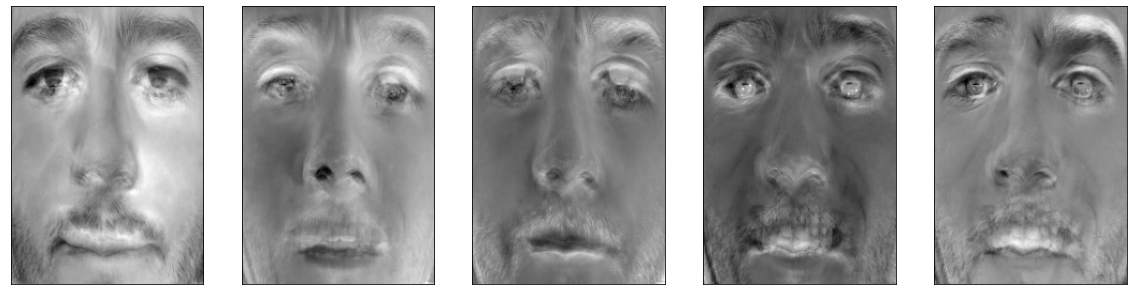

In [10]:
eigen_disp = []
for i in range(5):
    img = eigen_faces[i]
    img = img.reshape(height, width)
    eigen_disp.append(img)

    
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1,5,i+1), plt.imshow(eigen_disp[i], cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    
plt.show()

# 3 Neighbourhood clustering

In [11]:
def getAccuracy(vector, subjects):
    vector = np.transpose(vector)
    count = 0
    for i in range(len(vector)):
        min = float('inf') 
        for j in range(len(vector)):
            if i != j:
                dist = np.linalg.norm(vector[i]-vector[j], ord=2)
                if dist < min:
                    min = dist
                    index = j
        if subjects[i] == subjects[index]:
            count += 1
    accuracy = count*100/len(vector)
    return accuracy

In [12]:
acc_org = getAccuracy(img_vector, subject)
acc_eig = getAccuracy(eigen_vectors, subject)
acc_norm = getAccuracy(normalized_img_vector, subject)
print(f'Original high dimensional pixel space accuracy: ' + str(acc_org) + "%")
print(f'Normalized high dimensional pixel space accuracy: ' + str(acc_norm) + "%")
print(f'Eigenspace accuracy: ' + str(acc_eig) + "%")

Original high dimensional pixel space accuracy: 70.0%
Normalized high dimensional pixel space accuracy: 100.0%
Eigenspace accuracy: 76.66666666666667%


#### Would you expect there to be a significant difference?

There should not be a significant difference in accuracy as the PCA method is expected by design to capture most of the information of the original pixel space in a smaller dimension. In my case the difference is just 6%. Also it is interesting to see that the accuracy of the normalized high dimension pixel space is 100%.

# 4 Face Detection and Recognition

In [13]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(100, 250, stepSize):
        for x in range(0, 1000, stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [14]:
def findFace(winSize, resizeDim, stride, threshold, test_img, img_vector_mean, eigen_faces, weights):
    (winW, winH) = winSize    #window size
    stepSize = stride                #stride
    people = []
    names = []
    test_out = test_img.copy()
    # extract overlapping windows from the test image and process each
    for (x, y, window) in sliding_window(test_img, stepSize, (winW, winH)):
       
         # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
            
        #resize each window
        window = cv2.resize(window, dim, interpolation = cv2.INTER_AREA)
            
        window_org = window
        
        # process each window
        window = window.reshape(pixels, 1)
        test_norm_face = window - img_vector_mean
        test_weight = np.transpose(test_norm_face).dot(np.transpose(eigen_faces))
        norm = np.linalg.norm(test_weight - weights, ord=2, axis=1)
        dist = min(norm)
        
        # if distance is less than threahold distance then the window contains a face
        if (dist < threshold):
            print(dist )
            cv2.rectangle(test_out, (x, y), (x + winW, y + winH), (255, 255, 255), 3)
            # identify the person in the window
            index = np.argmin(norm)
            people.append(window_org)
            names.append(subject[index])



    # view the test image with all faces detected
    fig=plt.figure(figsize=(20, 24), dpi= 80)
    plt.subplot(121), plt.imshow(test_out, cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    
    # show result of identification of each person in detected faces
    plt.figure(figsize=(20, 10))
    for i in range(len(people)):
        plt.subplot(3,10,i+1), plt.imshow(people[i], cmap = 'gray')
        plt.title(names[i])
        plt.xticks([]), plt.yticks([])

    plt.show()
    
    return people

4881062.922414123
4652093.119448375
4681004.4385017725


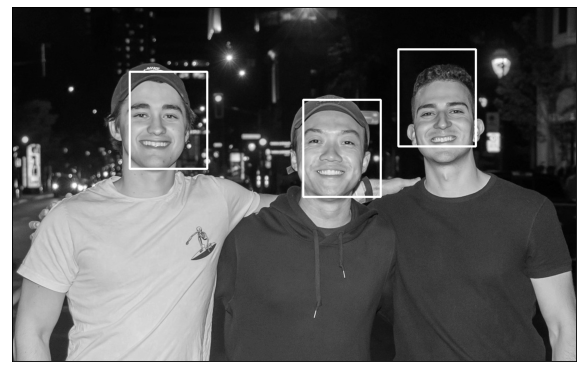

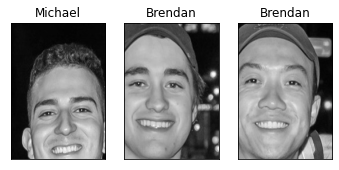

In [15]:
windowDim = (180,225)

detections = findFace(windowDim, dim, 13, 5000000, test_pic, img_vector_mean, eigen_faces, weights)

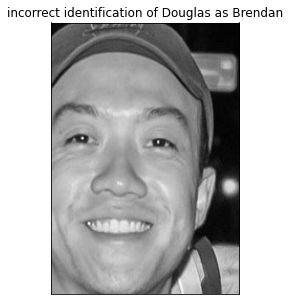

In [16]:
doug_incorrect = detections[-1]
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1), plt.imshow(doug_incorrect, cmap = 'gray')
plt.title("incorrect identification of Douglas as Brendan")
plt.xticks([]), plt.yticks([])
plt.show()


In [17]:
# process douglas picture
doug_incorrect = doug_incorrect.reshape(pixels, 1)
doug_incorrect_norm = doug_incorrect - img_vector_mean
doug_incorrect_weight = np.transpose(doug_incorrect_norm).dot(np.transpose(eigen_faces))
norm = np.linalg.norm(doug_incorrect_weight - weights, ord=2, axis=1)

#sort distances and subject names based on distances
norm_sorted = sorted(norm)
norm_sorted= np.array(norm_sorted)
subject = [subject for _,subject in sorted(zip(norm_sorted,subject))]


for i in range(30):
    if (subject[i] == 'Douglas'):
        print("Need " + str(i) + " neighbours before getting correct label.")
        break

Need 10 neighbours before getting correct label.


This method works pretty well.
All 3 three faces are perfectly detected. However, Douglas is incorrectely identified as Brendan. But it must be noted that in this particular test image they do look similar. We need 10 neighbours before getting the correct label. This approach would fail if the clusters of subjects are very close to other clusters. This method is also very susceptible to chnages in lighting and any occulusions. It is also important to note that in the test image the subjects are wearing whereas they arent in the training images. 